## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
###  This notebook is an example of camera calibration, function implementation can see in calibration.py

### Main code of this project see in main.py

---
## Camera Calibration

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt


# 设置寻找亚像素角点的参数，采用的停止准则是最大循环次数30和最大误差容限0.001
criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    size = gray.shape[::-1]
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

# 标定
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size, None, None)
 
print("ret:",ret)
print("mtx:\n",mtx)        # 内参数矩阵
print("dist:\n",dist)      # 畸变系数   distortion cofficients = (k_1,k_2,p_1,p_2,k_3)
print("rvecs:\n",rvecs)    # 旋转向量  # 外参数
print("tvecs:\n",tvecs)    # 平移向量  # 外参数

ret: 0.8457746434698576
mtx:
 [[  1.15694046e+03   0.00000000e+00   6.65948821e+02]
 [  0.00000000e+00   1.15213880e+03   3.88784787e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist:
 [[ -2.37638046e-01  -8.54042640e-02  -7.90999564e-04  -1.15882270e-04
    1.05726173e-01]]
rvecs:
 [array([[ 0.5134285 ],
       [-0.21553753],
       [ 0.02807188]]), array([[ 0.0371615 ],
       [ 0.45959728],
       [ 0.00658237]]), array([[ 0.03581238],
       [ 0.64802428],
       [ 0.01020059]]), array([[-0.32754339],
       [ 0.66183134],
       [-0.41498133]]), array([[ 0.05858405],
       [-0.51502591],
       [-0.00520217]]), array([[-0.02021531],
       [-0.48482757],
       [ 0.01852591]]), array([[ 0.04403697],
       [-0.4608846 ],
       [-0.05739228]]), array([[ 0.21950509],
       [-0.06364462],
       [ 0.01173294]]), array([[ 0.17554643],
       [-0.05666319],
       [-0.0016564 ]]), array([[ 0.08891527],
       [ 0.38639697],
       [ 0.05540599]]), array([[ 0.63548358]

In [5]:
images = glob.glob('../camera_cal/calibration*.jpg')
print(images)

['../camera_cal\\calibration1.jpg', '../camera_cal\\calibration10.jpg', '../camera_cal\\calibration11.jpg', '../camera_cal\\calibration12.jpg', '../camera_cal\\calibration13.jpg', '../camera_cal\\calibration14.jpg', '../camera_cal\\calibration15.jpg', '../camera_cal\\calibration16.jpg', '../camera_cal\\calibration17.jpg', '../camera_cal\\calibration18.jpg', '../camera_cal\\calibration19.jpg', '../camera_cal\\calibration2.jpg', '../camera_cal\\calibration20.jpg', '../camera_cal\\calibration3.jpg', '../camera_cal\\calibration4.jpg', '../camera_cal\\calibration5.jpg', '../camera_cal\\calibration6.jpg', '../camera_cal\\calibration7.jpg', '../camera_cal\\calibration8.jpg', '../camera_cal\\calibration9.jpg']


## Undistortion

(720, 1280, 3)
[[ 990.39678955    0.          674.02407776]
 [   0.          980.86248779  390.81476527]
 [   0.            0.            1.        ]]
------------------使用undistort函数-------------------
(629, 1212, 3)


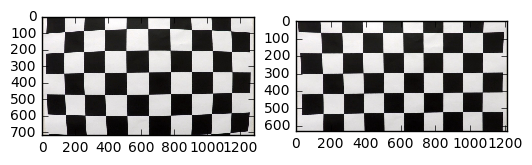

In [43]:
img = cv2.imread(images[0])
print(img.shape)
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
print(newcameramtx)

print("------------------使用undistort函数-------------------")
dst = cv2.undistort(img,mtx,dist,None,newcameramtx)
x,y,w,h = roi
dst1 = dst[y:y+h,x:x+w]
#cv2.imwrite('calibresult11.jpg', dst1)
print(dst1.shape)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(dst1, cv2.COLOR_BGR2RGB))
plt.show()

-------------------使用重映射的方式-----------------------
方法二:dst的大小为: (579, 1175, 3)


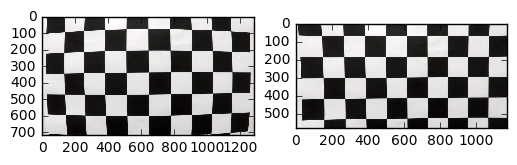

In [37]:

# undistort方法二
print("-------------------使用重映射的方式-----------------------")
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)  # 获取映射方程
#dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)      # 重映射
dst = cv2.remap(img,mapx,mapy,cv2.INTER_CUBIC)        # 重映射后，图像变小了
x,y,w,h = roi
dst2 = dst[y:y+h,x:x+w]
#cv2.imwrite('calibresult11_2.jpg', dst2)
print("方法二:dst的大小为:", dst2.shape)        # 图像比方法一的小
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(dst2, cv2.COLOR_BGR2RGB))
plt.show()

## Re-projection Error

In [38]:

print("-------------------计算反向投影误差-----------------------")
tot_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i],rvecs[i],tvecs[i],mtx,dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    tot_error += error
 
mean_error = tot_error/len(objpoints)
print("total error: ", tot_error)


-------------------计算反向投影误差-----------------------
total error:  1.8430478696046702


## Undistortion on Test Image

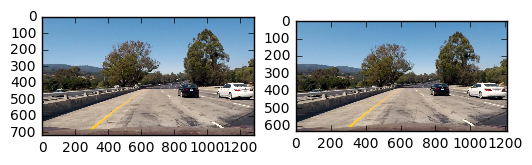

In [78]:
%run ../calibration
cal_images_dir = '../camera_cal/calibration*.jpg'
ret, mtx, dist, rvecs, tvecs=calibrate(cal_images_dir)

img=cv2.imread('../test_images/test1.jpg')
dst=undistort(img,mtx,dist)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()

## Pipeline Functions Visualization

In [75]:
%run ../pipeline
%matplotlib inline








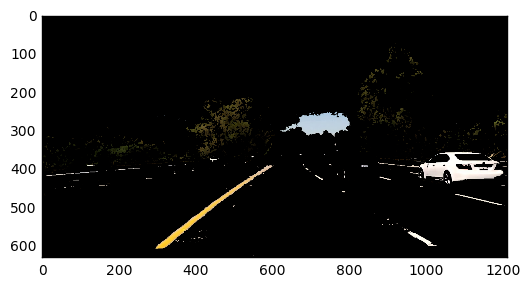

In [76]:
t1=select_line_color(dst)
plt.imshow(t1)

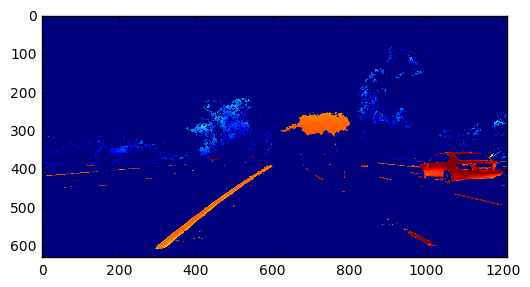

In [77]:
t2=grayscale(t1)
plt.imshow(t2)

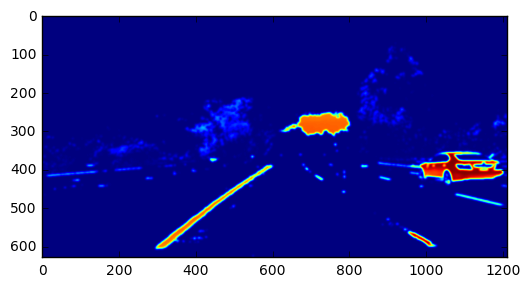

In [59]:
t3=gaussian_blur(t2, 15)
plt.imshow(t3)

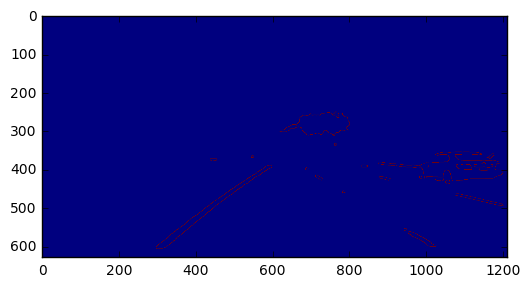

In [61]:
t4=canny(t3, low_threshold=50, high_threshold=150)
plt.imshow(t4)

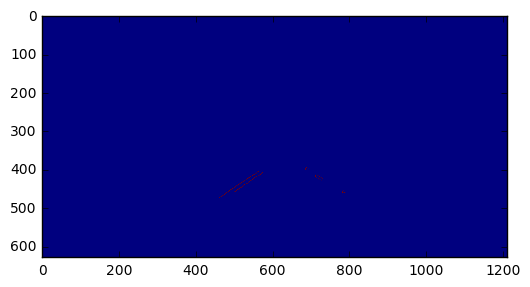

In [64]:
rows, cols = t4.shape[:2]
vertices = np.array([[[cols*0.1, rows*0.95],[cols*0.4, rows*0.6],[cols*0.9, rows*0.95],[cols*0.6, rows*0.6]]],dtype=np.int32)
t5 = region_of_interest(t4, vertices)
plt.imshow(t5)